# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>2) Supervised Approach: Naive Baseline</b>

___
# <b>Table of Content</b> <a id="toc_"></a>

* [<b>Baseline</b>](#baseline)
    * [k-Nearest-Neighbor Classifier](#knn)
    * [Supervised Clustering: k-Means](#kmeans)
   
In this notebook we report all the experiments related to the baseline. We generate features representing IPs by considering the top-5 ports of each ground truth class. Then, being a completely supervised approach, we run a 7-Nearest-Neighbor classifier on the last day dataset with $GT+1$ classes $= GT$ classes + Unknown:
In our experiments, $GT=9$, thus we have 10 classes.


Finally, we run the k-Means algorithm on the dataset for the classification of the 10 classes.



___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

In [1]:
DEMONSTRATIVE = True

In [1]:
from config import *
from src.corpus import get_services
from src.preprocess import *
from src.knnClassifier import *
from src.baseline import *
from sklearn.cluster import KMeans
from src.callbacks import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

default_cc = (cycler('color',['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))

___

# <b>Baseline</b><a id='baseline'></a>

As a very simple approach let's consider the last day of traffic. After the filtering, 
there are`G = g + 1` classes, where `g` are the ground truth classes and `G` is the number of
classes plus the `unknown`.

Assuming a port-based classifier as a baseline, we define `G`, features. Each one is the fraction
of daily packets sent to each top-5 ports for each ground truth class.

In [3]:
raw_data = load_raw_data('20210331')
daily = filter_data(raw_data, '20210331')
# Get the class of services
daily['serv'] = daily.pp.apply(get_services)
# Add a ones column for packets sum
daily['pkts'] = 1

daily.head()

,ts,ip,port,proto,pck_len,pp,serv,pkts
ts,,,,,,,,
2021-03-30 22:29:08.691001,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp,dbs,1
2021-03-30 22:29:08.691010,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp,dbs,1
2021-03-30 22:29:08.811067,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp,unk_usr,1
2021-03-30 22:29:08.811073,2021-03-30 22:29:08.811073,172.245.10.231,3699,tcp,54,3699/tcp,unk_usr,1
2021-03-30 22:29:09.119676,2021-03-30 22:29:09.119676,119.237.180.88,5555,tcp,74,5555/tcp,unk_usr,1


In [4]:
# Load the ground truth
gt = pd.read_csv(GT).drop(columns=['Unnamed: 0'])
ips = daily.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})

print(lookup.shape)
lookup.head(3)

(22399, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


Build the baseline dataset

In [5]:
baseline = build_dataset_from_raw(daily.merge(lookup, on='ip', how='left'), 5)
baseline.head()

,15/tcp,3000/tcp,4222/tcp,587/tcp,5060/tcp,2000/tcp,443/tcp,445/tcp,53/udp,161/udp,...,54321/tcp,30005/tcp,2087/tcp,50000/tcp,22/tcp,9200/tcp,21/tcp,1433/tcp,123/udp,class
ip,,,,,,,,,,,,,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.138.147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai


## <b>k-Nearest-Neighbors Classifier</b><a id='knn'></a>
We run a 7-Nearest-Neighbors classifier for evaluating the embeddings. 

In [7]:
knn = KnnClassifier(baseline, 7)
knn.fit_predict()
report = knn.get_report(output_dict=False, labels=lookup['class'].unique())

print(report)

                 precision    recall  f1-score   support

          mirai       0.97      1.00      0.98      7351
internet-census       0.50      0.67      0.57       103
     binaryedge       0.97      0.67      0.80       101
      sharashka       0.94      0.32      0.48        50
           ipip       0.00      0.00      0.00        49
    engin-umich       0.71      1.00      0.83        10
         censys       0.83      0.42      0.56       336
         shodan       0.75      0.13      0.22        23
     stretchoid       0.43      0.03      0.05       104

      micro avg       0.95      0.94      0.95      8127
      macro avg       0.68      0.47      0.50      8127
   weighted avg       0.94      0.94      0.93      8127



## <b>Supervised Clustering: k-Means</b><a id='kmeans'></a>

Finally, we run a k-Means with 10 classes (9 ground truth classes + 1 unknown). In this way, if the port-based classifier would be enough, each class should be assigned to a unique cluster.

In [8]:
kmeans = KMeans(10)
y_pred = kmeans.fit_predict(baseline.drop(columns=['class']).to_numpy(), baseline['class'].values)

In [9]:
baseline['cluster'] = [f'C{c}' for c in y_pred]
baseline.head()

,15/tcp,3000/tcp,4222/tcp,587/tcp,5060/tcp,2000/tcp,443/tcp,445/tcp,53/udp,161/udp,...,30005/tcp,2087/tcp,50000/tcp,22/tcp,9200/tcp,21/tcp,1433/tcp,123/udp,class,cluster
ip,,,,,,,,,,,,,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai,C1
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.138.147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai,C0


Generate heatmap

In [10]:
pivot = pivot_clusters(baseline)
pivot

cluster,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
class,,,,,,,,,,
binaryedge,NaN,82.178218,NaN,NaN,NaN,NaN,NaN,17.821782,NaN,NaN
censys,NaN,81.547619,4.761905,NaN,NaN,NaN,NaN,8.928571,NaN,4.761905
engin-umich,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet-census,NaN,88.349515,NaN,NaN,NaN,NaN,NaN,11.650485,NaN,NaN
ipip,2.040816,85.714286,NaN,NaN,NaN,NaN,4.081633,2.040816,6.122449,NaN
mirai,75.853625,3.686573,NaN,6.053598,NaN,10.869269,0.013604,0.027207,NaN,3.496123
sharashka,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shodan,NaN,73.913043,NaN,NaN,NaN,NaN,NaN,26.086957,NaN,NaN
stretchoid,NaN,90.384615,0.961538,NaN,NaN,0.961538,3.846154,3.846154,NaN,NaN


<Figure size 640x480 with 0 Axes>

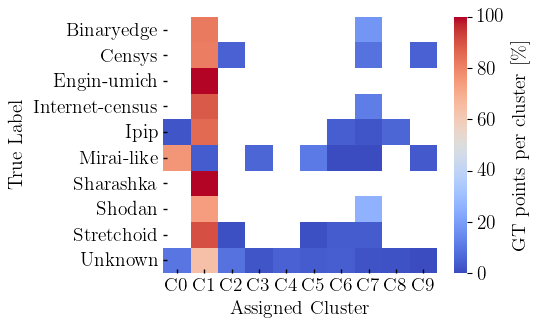

In [11]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: clusteringBaseline(plt, pivot),
                      figsize=(5.5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/baseline.pdf')
plot.show()